# CODE 2.0: Code for Optimizing Docking Enrichments

In [1]:
######Importa los paquetes necesarios
%pylab inline
import csv
import os
import random
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy import optimize
from scipy import stats
from __future__ import division
import pdb
import time
import sys
import shutil

#set_printoptions(hold='nan')
#rc('text', usetex=True, fontsize=20)

Populating the interactive namespace from numpy and matplotlib


In [2]:
ResultsDatabase=genfromtxt('Input.csv', delimiter=',') #[[0,0]]
ndxchg=0

In [3]:
Nombre='test'
inputfile='Input.csv' 

numParam=2
mayomen=[]

for i in range(0, numParam):
    mayomen.append(-1)
#mayomen=[-1,-1,-1,-1,-1,-1] #-1 si entre menor mejor y 1 si entre mayor mejor

numTrainMol=105
semilla=1
thresAct=1 #Por debajo (o igual) a este valor se considera el compuesto activo

coluAct=2
coluMIC=3
coluMICcal=4

iterac=500
aviso=50

pesot=5
thresComp=25
descrp=0
ndxchg=0

#iterac2=100
#########################################################################################################################

if os.path.exists(Nombre)==True:
    sys.exit("There is already a job with the same name. Please change it. I will not override it to then see you mad at me.")
if os.path.exists(Nombre)==False:
    os.mkdir(Nombre)

shutil.copy(inputfile, Nombre)
os.rename(Nombre+'/'+inputfile, Nombre+'/'+Nombre+'In.csv' )
Datos=genfromtxt(Nombre + '/'+Nombre+'In.csv', delimiter=',', skip_header=1) 

In [4]:
def arreglar(array):
    
    ignorar=len(array[0,:])-numParam-1
    
    for j in range (0, numParam):
        norm=0
        colu=ignorar+j
        minimo=min(array[:,colu])
        maximo=max(array[:,colu])
        
        if mayomen[j]==-1:
            for k in range(0, len(array[:,colu])):
                array[k,colu]=array[k,colu]-maximo
            norm=min(array[:,colu])
            for l in range(0, len(array[:,colu])):
                array[l,colu]=array[l,colu]/norm
                
        if mayomen[j]==1:
            for m in range(0, len(array[:, colu])):
                array[m, colu]=array[m,colu]-minimo
            norm=max(array[:,colu])
            for n in range(0, len(array[:,colu])):
                array[n, colu]=array[n, colu]/norm 
    
    for o in range(0,len(array[:,0])):
        if (array[o, coluMIC]<=thresAct):
            array[o,coluAct]=1
        if (array[o, coluMIC]>thresAct):
            array[o,coluAct]=2
    return array

In [5]:
filasTrain=[]
TrainSet=zeros((numTrainMol, len(Datos[0,:])))
filasTest=[]
TestSet=zeros((len(Datos[:,0])-numTrainMol,len(Datos[0,:])))

DatosArreg=arreglar(Datos)
matriz_propiedades = DatosArreg[:,len(DatosArreg[0,:])-1-numParam:(len(DatosArreg[0,:])-1)]
mic = DatosArreg[:,coluMIC]

for i in range(len(DatosArreg[0,:])):
    random.seed(semilla)
    filasTrain=random.sample(range(len(DatosArreg[:,0])), numTrainMol)
    
ndx=0
for j in range(0, len(DatosArreg[:,0])):
    if ((j in filasTrain)==True):
        TrainSet[ndx,:]=DatosArreg[j,:]
        ndx+=1   

        
for i in range(0, len(DatosArreg[:,0])):
    if ((i in filasTrain)==False):
        filasTest.append(i)

ndx=0
for k in range(0, len(DatosArreg[:,0])):
    if ((k in filasTest)==True):
        TestSet[ndx,:]=DatosArreg[k,:]
        ndx += 1

In [6]:
from emcee_code import emcee_code_function, modelo

In [7]:
print shape(mic)

(145,)


In [8]:
print shape(matriz_propiedades)

(145, 2)


Mean acceptance fraction: 0.713 (Should be between 0.25 and 0.5 approximately)
Parameter = [16 50 84]
('alfa1 = ', array([  9.57883587,  10.05713788,  10.50805725]))
('alfa2 = ', array([-4.71364028, -4.25675464, -3.77488579]))


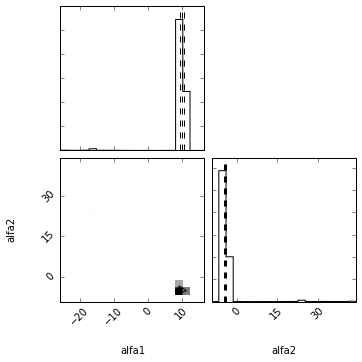

In [9]:
parametros_emcee = emcee_code_function(matriz_propiedades, mic, semilla)

parametros_sin_error = parametros_emcee[:,1]

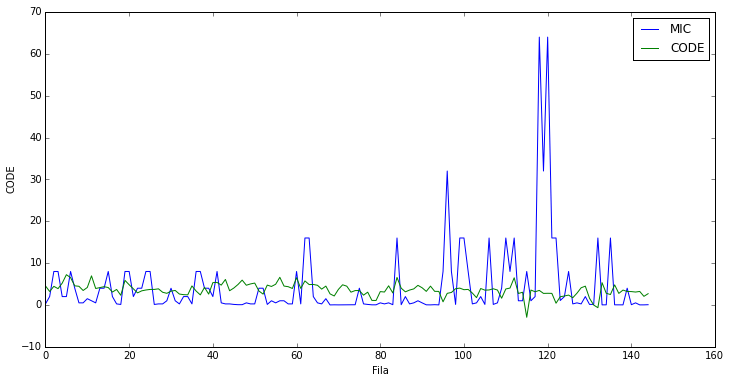

In [10]:
figure(figsize = (12,6))
plot(mic, label='MIC')
plot(modelo(matriz_propiedades, parametros_sin_error), label='CODE')
legend()
xlabel('Fila')
ylabel('CODE')

In [20]:
def escresultados(coefi, path):
    arch = open(path + '/' + Nombre + '.log', "a")
    
    arch.write('Job name: ' + Nombre)
    arch.write('\n Starting time: ' + str(start_mom))
    arch.write('\n Input file: ' + inputfile)
    arch.write('\n Number of parameters: ' + str(numParam))
    arch.write('\n MAYOMEN array: ' + str(mayomen))
    arch.write('\n Number of molecules in the Training Set: ' + str(numTrainMol))
    arch.write('\n Number of molecules in the Test Set: ' + str(len(DatosArreg[:,0])-numTrainMol))
    arch.write('\n Total molecules imported: ' + str(len(DatosArreg[:,0])))
    arch.write('\n Random seed: ' + str(semilla))
    arch.write('\n Activity Threshold: ' + str(thresAct))
    arch.write('\n Boolean activity set to column: ' + str(coluAct))
    arch.write('\n Numeric activity value taken from column: ' + str(coluMIC))
    arch.write('\n Calculated activity values set in column: ' + str(coluMICcal))
    arch.write('\n Iteration step shown every: ' + str(aviso))
    arch.write('\n Number of iterations: ' + str(iterac))
    arch.write('\n Slope extra weight: ' + str(pesot))
    arch.write('\n Percentage of screened compounds that receive the slope extra weight: ' + str(thresComp))
    arch.write('\n Finish time: ' + str(finish_mom))
    arch.write('\n Running time (s): ' + str(abs(time.time()-start_time)))
    
    arch.write('\n \n The best parameters found were: ' + str(coef))
    arch.write('\n \n The calibration curve had an r^2 of: ' + str(datcali[2]**2))
    arch.write('The equation of this line is: y = ' + str(datcali[0]) + 'x + ' + str(datcali[1]))
    arch.write('\n \n With the best coeficients an r^2 of ' + str(datrepcal[2]**2) + ' is obtained between the calculated and the reported MIC for the Test Set')
    arch.write('\n The equation of this line is: y = ' + str(datrepcal[0]) + 'x + ' + str(datrepcal[1]))
     
    arch.write('\n \n With the best parameters, the enrichment curve has a weighted slope of: ' + str(-1*pendfunc(CODEfunc(DatosArreg, coefi), len(DatosArreg[0,:])-1)))
    arch.write('\n With the best parameters, the r-CODE value of the enrichment curve is: ' + str(rCODE(DatosArreg, coefi)))
    arch.write('\n Remember that the r-CODE value can take calues between 1.0 (ideal) and ' + str(-1/pendfunc(DatosArreg, coluAct)) + ' (random) ')
    
    if descrp==1:
        arch.write('\n \n Job description: In this job CODE was used to predict activity values')
    if descrp==2:
        arch.write('\n \n Job description: In this job CODE was used to maximize the weighted slope of the enrichment curve')
        
    if ndxchg==1:
        arch.write('\n \n ¡¡¡¡¡The signs of the coefficients were inverted!!!!!')
        
    arch.close()
    
    msj='Toda la informacion de este calculo se salvo en la carpeta: ' + Nombre
    print msj

0
A new global minimum was found on step 0
A new global minimum was found on step 2
A new global minimum was found on step 36
A new global minimum was found on step 1288
8192
16384
24576
32768
40960
49152
57344
65536
73728
The best parameters for reproducing the reported inhibition values are: [  2.3360308  -16.09950044 -74.19633542]

With these parameters an r^2 of 0.149289792342 is obtained for the calibration curve between the CODE function and the reported activities
 
The equation of this line is: y = 0.228903114775x + 16.7113577876


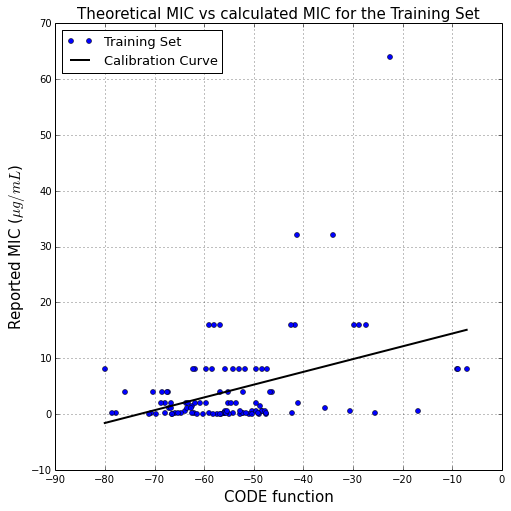



With the best coeficients an r^2 of 0.0532293968458 is obtained between the calculated and the reported MIC for the Test Set

The equation of this line is: y = 0.877583763385x + 0.869350363673


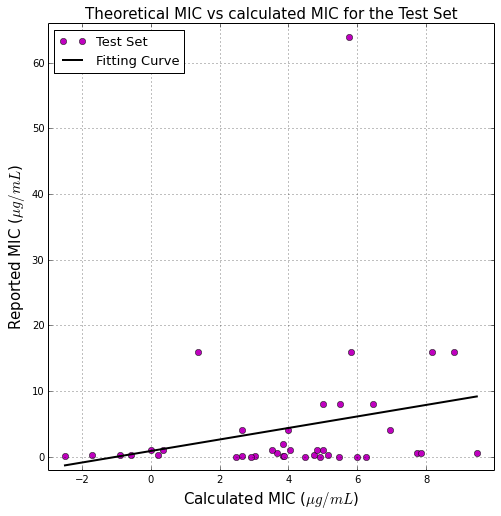




Con los mejores parametros se obtiene una pendiente ponderada en la curva de enriquecimiento de: 1.08745817469

Con los mejores parametros se obtiene un valor r-CODE de: 0.607476635514

Recuerde que r-CODE puede tomar valores entre 1.0 (Ideal) y 0.558620689655 (Aleatorio) 


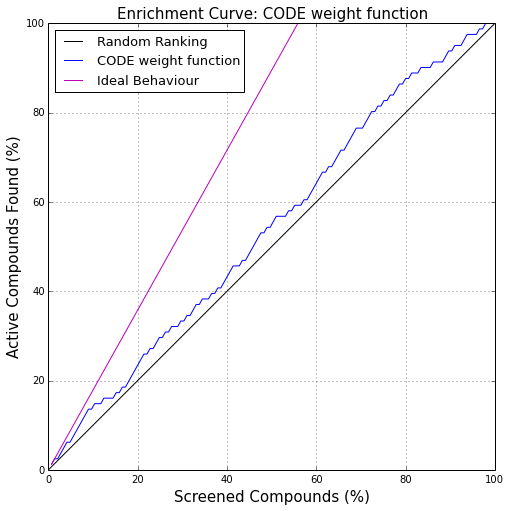

--- 23476.584888 segundos ---
Toda la informacion de este calculo se salvo en la carpeta: IteracTemp


In [22]:
iterac=81920
for i in range(0, 1):
    aviso=int(iterac/10)

    start_mom=time.strftime("%c")
    start_time = time.time()  

    coef=minimizacion(iterac); descrp=1
    if (calibracion(coef)[0]<0):
        coef[:]=coef[:]*-1
        ndxchg=1

    def datrepcal(array):
        reporcalcu=stats.linregress(array[:, coluMICcal], array[:, coluMIC])
        return reporcalcu

    datcali=calibracion(coef)
    Traincali=CODEfunc(TrainSet, coef)
    rescali(Nombre)
    testfinal=MICcal(TestSet, coef)
    datrepcal=datrepcal(testfinal)
    restest(Nombre)
    resenrique(coef, Nombre)

#coef2=minimizacion2(1); descrp=2
#resenrique(coef)

    finish_mom=time.strftime("%c")
    finish_time=time.time()

    print("--- %s segundos ---" % abs((finish_time - start_time)))
    escresultados(coef, Nombre)

    resulTemp=[[iterac, finish_time - start_time]]#[[count, numParam, iterac, finish_time - start_time, datcali[2]**2, datrepcal[2]**2, datrepcal[0], -1*pendfunc(CODEfunc(DatosArreg, coef), len(DatosArreg[0,:])-1), rCODE(DatosArreg, coef)]]

    ResultsDatabase=append(ResultsDatabase, resulTemp, axis=0)

    savetxt('IteracTemp.csv', ResultsDatabase, delimiter=',', newline='\n')
    ndxchg=0
    iterac=iterac*2